In [1]:
import pandas as pd
import numpy as np
import surprise
import matplotlib.pyplot as plt
import os

In [2]:
train = pd.read_csv("C:/Users/Srujan/Documents/Datasets/Recommender Systems/Analytics Vidhya/train/train_submissions.csv",sep=',')
train.head()

,user_id,problem_id,attempts_range
0,user_232,prob_6507,1
1,user_3568,prob_2994,3
2,user_1600,prob_5071,1
3,user_2256,prob_703,1
4,user_2321,prob_356,1


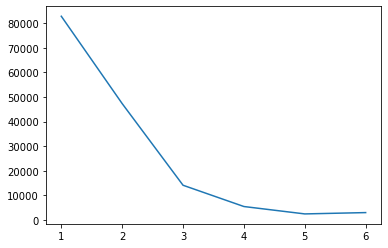

In [3]:
plt.plot(train.groupby('attempts_range')['attempts_range'].count())

In [4]:
lowest_attempt = train['attempts_range'].min()
highest_attempt = train['attempts_range'].max()

In [5]:
reader = surprise.Reader(rating_scale = (lowest_attempt,highest_attempt))
data = surprise.Dataset.load_from_df(train,reader)

Building recommender system with singular value decomposition method

In [8]:
algo = surprise.SVD()
output = algo.fit(data.build_full_trainset())

pred = algo.predict(uid='user_232',iid='prob_6507')
score = pred.est
print(score)

1.9314167906976176


predicting the attempts range for user 3568 and problem 2994

In [9]:
pred = algo.predict(uid='user_3568',iid='prob_2994')
score = pred.est
print(score)

2.3403882822654616


In [10]:
# all unique problems
pids = train['problem_id'].unique()

# problems which user 1600 has attempted 
pids1600 = train.loc[train['user_id'] == 'user_1600' ,'problem_id']

In [11]:
pids

array(['prob_6507', 'prob_2994', 'prob_5071', ..., 'prob_4986',
       'prob_1486', 'prob_1016'], dtype=object)

In [12]:
pids1600

2         prob_5071
9874      prob_1304
22231     prob_4260
22922     prob_2463
26697     prob_5932
31667     prob_2052
49702     prob_6072
58975     prob_5026
59526     prob_6228
67814     prob_1734
74167     prob_2022
77827     prob_3626
90558     prob_5781
92230     prob_2754
92559      prob_697
102927    prob_5970
103504    prob_2264
110223    prob_1689
122874    prob_1675
124399    prob_1966
135025    prob_2121
137358    prob_5478
142861    prob_5337
144437    prob_5441
146167     prob_332
151298    prob_5995
155166    prob_4068
Name: problem_id, dtype: object

In [13]:
#the problems which user_1600 has not attempted are 

pids_unattempted_1600 = np.setdiff1d(pids,pids1600)
pids_unattempted_1600

array(['prob_1', 'prob_10', 'prob_100', ..., 'prob_997', 'prob_998',
       'prob_999'], dtype=object)

Now we will be predicting the attempts range for unattempted problems by user 1600

In [14]:
### ratings arbitrarily set to 0
testset = [['user_1600',pid,0.] for pid in pids_unattempted_1600]
predictions = algo.test(testset)
predictions[5]

Prediction(uid='user_1600', iid='prob_1002', r_ui=0.0, est=1.8590800492215112, details={'was_impossible': False})

In [23]:
surprise.accuracy.rmse(predictions,verbose=True)

RMSE: 1.9559


1.955878920791301

In [15]:
pred_ratings = np.array([pred.est for pred in predictions])
pred_ratings

array([1.80139475, 2.23668205, 1.80963271, ..., 1.45445488, 1.92786276,
       2.32520267])

In [16]:
print(pred_ratings.min())
pids_unattempted_1600[np.argmin(pred_ratings)]

1.0616566836814105


'prob_4368'

In [17]:
import heapq
i_sorted_10 = heapq.nsmallest(10, range(len(pred_ratings)), pred_ratings.take)
top_10_items = pids_unattempted_1600[i_sorted_10]
print(top_10_items)

['prob_4368' 'prob_4667' 'prob_5777' 'prob_1607' 'prob_3038' 'prob_1537'
 'prob_2791' 'prob_5585' 'prob_265' 'prob_3864']


In [19]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

In [20]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9684796658403
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


Result of above grid search

0.9684796658403

{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}

In [21]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
algo.fit(data.build_full_trainset())

In [29]:
testset = [['user_9999',pid,0.] for pid in pids_unattempted_1600]
predictions = algo.test(testset)
predictions[5]

Prediction(uid='user_9999', iid='prob_1002', r_ui=0.0, est=1.7547090629229034, details={'was_impossible': False})

In [30]:
pred_ratings = np.array([pred.est for pred in predictions])
pred_ratings

array([1.73731697, 2.31785718, 1.66136682, ..., 1.28853904, 1.75203355,
       2.39694692])

## Recommending easy problems

In [31]:
print(pred_ratings.min())
pids_unattempted_1600[np.argmin(pred_ratings)]

1.0


'prob_3038'

In [32]:
i_sorted_10 = heapq.nsmallest(10, range(len(pred_ratings)), pred_ratings.take)
top_10_items = pids_unattempted_1600[i_sorted_10]
print(top_10_items)

['prob_3038' 'prob_3006' 'prob_5585' 'prob_705' 'prob_6358' 'prob_6266'
 'prob_522' 'prob_6230' 'prob_2791' 'prob_4368']


## Recommending tough problems

In [33]:
print(pred_ratings.max())
pids_unattempted_1600[np.argmax(pred_ratings)]

4.015654061732257


'prob_2156'

In [34]:
i_sorted_10 = heapq.nlargest(10, range(len(pred_ratings)), pred_ratings.take)
top_10_items = pids_unattempted_1600[i_sorted_10]
print(top_10_items)

['prob_2156' 'prob_4241' 'prob_2304' 'prob_3713' 'prob_4114' 'prob_1833'
 'prob_2272' 'prob_1922' 'prob_5335' 'prob_244']
